In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential, Model
from keras.layers import Dense
from keras.optimizers import RMSprop
import tensorflow as tf

df=pd.read_csv(r'C:\Sibi\Research\Implementation\creditcard.csv')

**CLASS IMBALANCE IN GIVEN DATASET**

The number of records with Class 0 is 284315
The number of records with Class 1 is 492


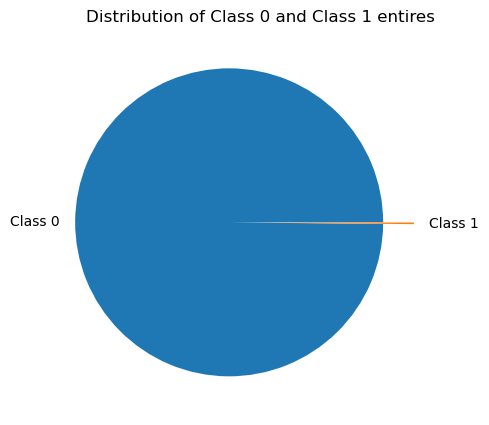

In [28]:
class1=df[df['Class']==1]
class0=df[df['Class']==0]
print("The number of records with Class 0 is",class0.shape[0])
print("The number of records with Class 1 is",class1.shape[0])
plt.figure(figsize=(5,5))
plt.pie([class0.shape[0],class1.shape[0]], labels=["Class 0", "Class 1"],explode=[0.2,0])
plt.title("Distribution of Class 0 and Class 1 entires")
plt.show()

In [30]:
#Filtering our data for class 1 due to imbalance
X = df[df["Class"]==1]

#Normalizing our features to range [-1,1]
X_train = (X - np.mean(X, axis = 0))/np.std(X, axis = 0)

In [34]:
#Generator Model
def define_generator():
    model = Sequential()
    model.add(tf.keras.Input(shape=(100,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(1028, activation='relu'))
    model.add(Dense(30, activation='tanh'))
    return model

#Critic Model
def define_critic():
    model=Sequential()
    model.add(tf.keras.Input(shape=(30,)))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(1))
    return model

#Wasserstein Loss Function
def wasserstein_loss(y_pred, y_true):
    return tf.reduce_mean(y_true*y_pred)

''' The function calculates the Wasserstein loss used in WGANs. It takes two inputs: y_true, the labels for samples (-1 for real and +1 for fake), 
and y_pred, the critic's predicted scores. The loss is computed as the mean of the product y_true * y_pred, which measures how well the critic 
distinguishes real samples (negative values) from fake samples (positive values). A lower loss indicates that the generator is producing more 
realistic samples.'''

test_gen=define_generator()
test_gen.summary()

test_critic=define_critic()
test_critic.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_7 (Dense)                      │ (None, 256)                 │          25,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1028)                │         527,364 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 30)                  │          30,870 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 715,674 (2.73 MB)

 Trainable params: 715,674 (2.73 MB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_11 (Dense)                     │ (None, 512)                 │          15,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 1024)                │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │           1,025 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 542,209 (2.07 MB)

 Trainable params: 542,209 (2.07 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
def save_generated_records(epoch, generator, filename='wgan_new_augment.xlsx'):
    noise = np.random.normal(0, 1, (1000, 100))  # Generate 1000 samples for saving
    generated_record = generator.predict(noise)
    generated_record[:, -1] = 1
    
    # Create a DataFrame for the generated records
    columns = [f'V{i+1}' for i in range(28)]
    columns.extend(['Amount', 'Class']) 
    df_generated = pd.DataFrame(generated_record, columns=columns)
    
    # Save to Excel file with a new sheet for each epoch
    with pd.ExcelWriter(filename, engine='xlsxwriter') as writer:
        df_generated.to_excel(writer, sheet_name=f'Epoch_{epoch}', index=False)

    print(f"Generated records saved to {filename} for epoch {epoch}.")

In [ ]:
def train_gan(X_train, epochs=10, batch_size=128):
    ''' We setup the WGAN by first creating instances of the generator and the critic. Then we compile the critic with the loss function and the 
        optimizer as a preparation step before training. Once we have prepped the critic, we have to prepare the generator to take in feedback from 
        the critic and generate new samples and furthermore we compile that too. During each epoch, we will use these pre-defined and compiled models 
        to perform training iterations without needing to redefine or recompile them.'''
    
    generator=define_generator()
    crtic=define_critic()
    critic.compile(loss=wasserstein_loss, optimizer=RMSprop(learning_rate=0.0005))

    noise=tf.keras.Input(shape=(100,))
    generated_features=generator(noise)
    critic.trainable=False
    validity=critic(generated_features)
    combined=tf.keras.Model(noise, validity)
    combined.compile(loss=wasserstein_loss, optimizer=RMSprop(learning_rate=0.0005))

    for epoch in tqdm(range(epochs)), desc "Training Process"):
        print("@ Epoch", epoch)

        for _ in range(batch_size):
            idx=np.random.randint(0, X_train.shape[0], batch_size)
            real_features=X_train.iloc[idx].values

            new_noise=np.random.normal(0,1, (batch_size, 100))
            fake_features=generator.predict(noise)

            d_loss_real=critic.train_on_batch(real_features, -np.ones((batch_size, 1)))
            d_loss_fake=critic.train_on_batch(fake_features, np.ones((batch_size, 1)))

            for layer in critic.layers:
                weights=layer.get_weights()
                weights=[np.clip(w,-0.01,0.01) for w in weights]
                layer.set_weights(weights)

        new_noise=np.random.normal(0,1,(batch_size,100))
        g_loss=combined.train_on_batch(noise, -np.ones((batch_size,1)))

        save_generated_records(epochs, generator)

        if epoch % 1 == 0:
            print(f"{epoch} [D loss: {d_loss_real + d_loss_fake:.4f}] [G loss: {g_loss:.4f}]")

# Start training with your dataset
train(X_train=X_train.drop(columns="Time"), epochs=10, batch_size=128)